## Data Analysis on 311 Service Request data from Open Data NYC and Census Population

###### Load library dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

###### Load 311 Service Request data from Open Data NYC  and  Population by zip code -  ZCTA == zip 

In [2]:
#Load the 11 Service Request data from Open Data NYC. Can download from web site and load but have taken the direct route
#SR_311 = pd.read_json('C:\\Users\\eche1\\Downloads\\Nyc_OpenData_311ServiceRequests2017.json')
nyc_service_request_url = "https://data.cityofnewyork.us/resource/fhrw-4uyv.json?$where=created_date%20between%20%272017-01-01T00:00:00%27%20and%20%272018-01-01T00:00:00%27"
nyc_df = pd.read_json(nyc_service_request_url)

In [3]:
#Load the US Census population data as of 2017 to be used to extract NYC borough population via zip code
#population_ZipCode = pd.read_csv("C:\\Users\\eche1\\Downloads\\2010+Census+Population+By+Zipcode+(ZCTA).csv")
us_census_population_url = 'https://s3.amazonaws.com/SplitwiseBlogJB/2010+Census+Population+By+Zipcode+(ZCTA).csv'
population_ZipCode = pd.read_csv(us_census_population_url)

### Perform EDA, Preparation and possible Cleaning

In [4]:
#Explore dataset and data types
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 35 columns):
address_type                      995 non-null object
agency                            1000 non-null object
agency_name                       1000 non-null object
bbl                               879 non-null float64
borough                           1000 non-null object
city                              994 non-null object
closed_date                       991 non-null object
community_board                   1000 non-null object
complaint_type                    1000 non-null object
created_date                      1000 non-null object
cross_street_1                    830 non-null object
cross_street_2                    830 non-null object
descriptor                        1000 non-null object
due_date                          872 non-null object
facility_type                     1000 non-null object
incident_address                  935 non-null object
incident_zip         

In [5]:
#Explore
nyc_df.head(3)

,address_type,agency,agency_name,bbl,borough,city,closed_date,community_board,complaint_type,created_date,...,park_facility_name,resolution_action_updated_date,resolution_description,status,street_name,taxi_company_borough,taxi_pick_up_location,unique_key,x_coordinate_state_plane,y_coordinate_state_plane
0,LATLONG,DOHMH,Department of Health and Mental Hygiene,NaN,BROOKLYN,BROOKLYN,2017-01-05T00:00:00.000,Unspecified BROOKLYN,Rodent,2017-01-01T00:00:00.000,...,Unspecified,2017-01-05T00:00:00.000,The Department of Health and Mental Hygiene wi...,Closed,EAST 38TH STREET,NaN,NaN,35138559,1001444.0,165508.0
1,LATLONG,DOHMH,Department of Health and Mental Hygiene,NaN,BROOKLYN,BROOKLYN,2017-01-05T00:00:00.000,Unspecified BROOKLYN,Rodent,2017-01-01T00:00:00.000,...,Unspecified,2017-01-05T00:00:00.000,The Department of Health and Mental Hygiene wi...,Closed,NaN,NaN,NaN,35141040,995104.0,194730.0
2,ADDRESS,DOHMH,Department of Health and Mental Hygiene,4.096930e+09,QUEENS,Jamaica,2017-01-03T00:00:00.000,12 QUEENS,Rodent,2017-01-01T00:00:00.000,...,Unspecified,2017-01-03T00:00:00.000,The Department of Health and Mental Hygiene wi...,Closed,148 STREET,NaN,NaN,35143953,1037497.0,196172.0


In [6]:
#Explore datasets for nan values and shortlist data fields for further analysis
nyc_df.isna().sum()

address_type                        5
agency                              0
agency_name                         0
bbl                               121
borough                             0
city                                6
closed_date                         9
community_board                     0
complaint_type                      0
created_date                        0
cross_street_1                    170
cross_street_2                    170
descriptor                          0
due_date                          128
facility_type                       0
incident_address                   65
incident_zip                        6
intersection_street_1             936
intersection_street_2             936
latitude                            6
location                            6
location_type                      51
longitude                           6
open_data_channel_type              0
park_borough                        0
park_facility_name                  0
resolution_a

In [7]:
# Select subset of essential dataset fields for further analysis
subfields = ['unique_key','complaint_type','borough', 'city','incident_zip']

In [8]:
# Create DataFrames with subset of essential dataset fields for further analysis
nyc_df_dCols = nyc_df[subfields]
nyc_df_dCols.head()

,unique_key,complaint_type,borough,city,incident_zip
0,35138559,Rodent,BROOKLYN,BROOKLYN,11234.0
1,35141040,Rodent,BROOKLYN,BROOKLYN,11249.0
2,35143953,Rodent,QUEENS,Jamaica,11435.0
3,35144092,Food Poisoning,QUEENS,Jackson Heights,11372.0
4,35144123,Food Poisoning,QUEENS,Astoria,11105.0


In [9]:
#Extract the summation of the number of NaN values in a column
nyc_df_dCols.isna().sum()

unique_key        0
complaint_type    0
borough           0
city              6
incident_zip      6
dtype: int64

In [10]:
#Explore the fields with NaN values. Possible approach will be to use interpolate to fill the fields with NaN
nyc_df_dCols[nyc_df_dCols.isna().any(1)]

,unique_key,complaint_type,borough,city,incident_zip
143,35143285,Street Light Condition,MANHATTAN,NaN,NaN
165,35142755,Noise - Residential,Unspecified,NaN,NaN
615,35140527,Noise - Commercial,Unspecified,NaN,NaN
853,40845777,General Construction/Plumbing,QUEENS,NaN,NaN
905,40893488,General Construction/Plumbing,QUEENS,NaN,NaN
994,35144733,Noise - Residential,Unspecified,NaN,NaN


In [11]:
#Identified column that contain 'Unspecified'. Possible approach will be to use other fields like street_name to infer
nyc_df_dCols[nyc_df_dCols.isin(['Unspecified']).any(1)]

,unique_key,complaint_type,borough,city,incident_zip
165,35142755,Noise - Residential,Unspecified,NaN,NaN
615,35140527,Noise - Commercial,Unspecified,NaN,NaN
994,35144733,Noise - Residential,Unspecified,NaN,NaN


In [12]:
#For the borough with 'Unspecified' value, use their corresponding stree_name/incident_address values to make inference
#Can use web search to obtain corresponding borough.
nyc_df[['unique_key','street_name','incident_address']][nyc_df_dCols.isin(['Unspecified']).any(1)]

,unique_key,street_name,incident_address
165,35142755,POWELLS COVE BLVD,206 POWELLS COVE BLVD
615,35140527,LA 65 DE INFANTER&IACUTE;A,639 LA 65 DE INFANTER&IACUTE;A
994,35144733,60TH DRIVE,8517-8519 60TH DRIVE


In [13]:
#Assign value for missing borough and incident_zip based on inference from corresponding street_name/incident_address and web searches
nyc_df_dCols.index = nyc_df_dCols.unique_key

nyc_df_dCols.at[35142755,'borough'] = 'QUEENS'
nyc_df_dCols.at[35142755,'incident_zip'] = 11357

nyc_df_dCols.at[35140527,'borough'] = 'MANHATTAN'
nyc_df_dCols.at[35140527,'incident_zip'] = 10013

nyc_df_dCols.at[35144733,'borough'] = 'QUEENS'
nyc_df_dCols.at[35144733,'incident_zip'] = 11378

nyc_df_dCols.at[35143285,'incident_zip'] = 10013
nyc_df_dCols.at[40845777,'incident_zip'] = 11378
nyc_df_dCols.at[40893488,'incident_zip'] = 11378

In [14]:
#Check for remaining NaN values
nyc_df_dCols[nyc_df_dCols.isna().any(1)]

,unique_key,complaint_type,borough,city,incident_zip
unique_key,,,,,
35143285,35143285,Street Light Condition,MANHATTAN,NaN,10013.0
35142755,35142755,Noise - Residential,QUEENS,NaN,11357.0
35140527,35140527,Noise - Commercial,MANHATTAN,NaN,10013.0
40845777,40845777,General Construction/Plumbing,QUEENS,NaN,11378.0
40893488,40893488,General Construction/Plumbing,QUEENS,NaN,11378.0
35144733,35144733,Noise - Residential,QUEENS,NaN,11378.0


In [15]:
# Use interpolating with method 'pad' for string to fill replace NaN value at City field with corresponding borough
nyc_df_dCols = nyc_df_dCols.interpolate(method ='pad', limit =1)

In [16]:
#Check for any remaining NaN values in dataset column
nyc_df_dCols.isna().sum()

unique_key        0
complaint_type    0
borough           0
city              0
incident_zip      0
dtype: int64

## 1 - Consider only the 10 most common overall complaint types. For each borough, how many of each of those 10 types were there in 2017? 



###### Extract the 10 most common overall complaint types

In [17]:
#Extract the 10 most common overall complaint types
top10_complaint_types= nyc_df_dCols.groupby(['complaint_type']).size().sort_values(ascending=False)[:10]

In [18]:
#Display top 10 complaint types
top10_complaint_types

complaint_type
Noise - Residential        538
Noise - Commercial         102
Blocked Driveway            62
HEAT/HOT WATER              54
Noise - Street/Sidewalk     52
Illegal Parking             40
Rodent                      29
Street Condition            19
Noise - Vehicle             10
Taxi Complaint               8
dtype: int64

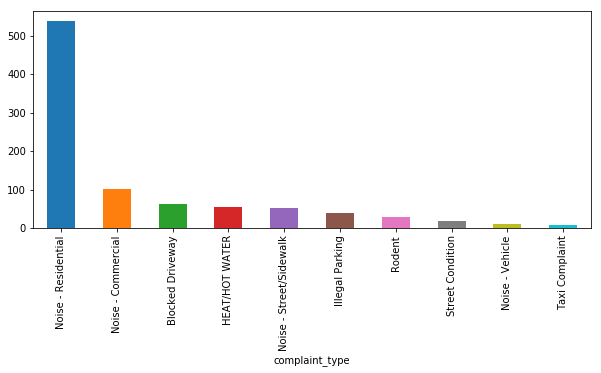

In [19]:
#Display top 10 complaint types
top10_complaint_types.plot(kind='bar', figsize=(10,4))

##### For each borough, how many of each of those 10 types were there in 2017?

In [20]:
#For each borough, how many of each of those 10 types were there in 2017?
temp_df1 = pd.DataFrame(columns=nyc_df_dCols.columns)
for i,s in nyc_df_dCols.iterrows():
    for x in top10_complaint_types.keys().values:
        if s.complaint_type == x:
            temp_df1 = temp_df1.append(s)         

In [21]:
temp_df1.groupby(['borough','complaint_type'])['borough'].agg(len)

borough        complaint_type         
BRONX          Blocked Driveway            17
               HEAT/HOT WATER              19
               Illegal Parking              7
               Noise - Commercial           2
               Noise - Residential        116
               Noise - Street/Sidewalk      2
               Noise - Vehicle              2
               Rodent                       3
BROOKLYN       Blocked Driveway            15
               HEAT/HOT WATER              23
               Illegal Parking             14
               Noise - Commercial          52
               Noise - Residential        146
               Noise - Street/Sidewalk     22
               Noise - Vehicle              3
               Rodent                      13
               Street Condition            10
               Taxi Complaint               2
MANHATTAN      HEAT/HOT WATER               8
               Illegal Parking              7
               Noise - Commercial        

## 2 - Consider only the 10 most common overall complaint types. For the 10 most populous zip codes, how many of each of those 10 types were there in 2017?

In [22]:
# Explore the population by zip code dataset
population_ZipCode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33092 entries, 0 to 33091
Data columns (total 2 columns):
Zip Code ZCTA             33092 non-null int64
2010 Census Population    33092 non-null int64
dtypes: int64(2)
memory usage: 517.1 KB


In [23]:
#Set the 'Zip Code ZCTA' as index
population_ZipCode.index = population_ZipCode['Zip Code ZCTA']

In [24]:
population_ZipCode.head()

,Zip Code ZCTA,2010 Census Population
Zip Code ZCTA,,
1001,1001,16769
1002,1002,29049
1003,1003,10372
1005,1005,5079
1007,1007,14649


In [25]:
#Reset the incident_zip date type and index in the SR_311_dCols dataframe to enable join between population_ZipCode
nyc_df_dCols['incident_zip'] = nyc_df_dCols['incident_zip'].astype('int64')
nyc_df_dCols.index = nyc_df_dCols.incident_zip

In [26]:
# Define expression that will obtain the range of the NYC borough zip code.
# This will enable the extraction of NYC borough population data from US Census data 
min_zipcode = population_ZipCode['Zip Code ZCTA'] >= nyc_df_dCols.index.min()
max_zipcode = population_ZipCode['Zip Code ZCTA'] <= nyc_df_dCols.index.max()

In [27]:
#Extract NYC borough population data from US Census data
NYC_population_ZipCode = population_ZipCode[population_ZipCode.where(min_zipcode & max_zipcode).notna().any(1)]

In [28]:
NYC_population_ZipCode.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401 entries, 10001 to 11694
Data columns (total 2 columns):
Zip Code ZCTA             401 non-null int64
2010 Census Population    401 non-null int64
dtypes: int64(2)
memory usage: 9.4 KB


In [29]:
#Extract 10 most populous zip codes from NYC_population_ZipCode
top10_NYC_population_ZipCode = NYC_population_ZipCode.sort_values(by=['2010 Census Population'],ascending=False)[:10]

In [30]:
#Display the 10 most populous zip codes
top10_NYC_population_ZipCode

,Zip Code ZCTA,2010 Census Population
Zip Code ZCTA,,
11368,11368,109931
11226,11226,101572
11373,11373,100820
11220,11220,99598
11385,11385,98592
10467,10467,97060
10025,10025,94600
11208,11208,94469
11236,11236,93877


In [31]:
#Join 311 Service request and NYC 10 most populous borough dataframes together on matching zip codes.
SR_311_top10_NYC_population_ZipCode = nyc_df_dCols.join(top10_NYC_population_ZipCode, how='inner')

In [32]:
#Review dataset and data types
SR_311_top10_NYC_population_ZipCode.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138 entries, 10025 to 11385
Data columns (total 7 columns):
unique_key                138 non-null int64
complaint_type            138 non-null object
borough                   138 non-null object
city                      138 non-null object
incident_zip              138 non-null int64
Zip Code ZCTA             138 non-null int64
2010 Census Population    138 non-null int64
dtypes: int64(4), object(3)
memory usage: 8.6+ KB


##### For the 10 most populous zip codes, how many of each of those 10 types were there in 2017?

In [33]:
# Consider only the 10 most common overall complaint types.  
# For the 10 most populous zip codes, how many of each of those 10 types were there in 2017? 
temp_df = pd.DataFrame(columns=SR_311_top10_NYC_population_ZipCode.columns)
for i , s in SR_311_top10_NYC_population_ZipCode.iterrows():
    for x in top10_complaint_types.keys().values:
        if s.complaint_type == x:
            temp_df = temp_df.append(s)      

In [34]:
temp_df.groupby(['incident_zip','complaint_type'])['incident_zip'].agg(len)

incident_zip  complaint_type         
10025         HEAT/HOT WATER              2
              Noise - Commercial          2
              Noise - Residential         6
              Noise - Street/Sidewalk     1
              Street Condition            1
10467         Blocked Driveway            2
              HEAT/HOT WATER              4
              Illegal Parking             1
              Noise - Residential        17
11207         Blocked Driveway            1
              HEAT/HOT WATER              2
              Noise - Commercial          1
              Noise - Residential         2
              Rodent                      2
11208         Blocked Driveway            1
              HEAT/HOT WATER              2
              Illegal Parking             1
              Noise - Residential         4
11220         Noise - Residential         4
11226         HEAT/HOT WATER              5
              Noise - Residential         9
11236         Blocked Driveway        

In [35]:
temp_df.groupby(['borough','incident_zip','complaint_type'])['incident_zip'].agg(len)

borough    incident_zip  complaint_type         
BRONX      10467         Blocked Driveway            2
                         HEAT/HOT WATER              4
                         Illegal Parking             1
                         Noise - Residential        17
BROOKLYN   11207         Blocked Driveway            1
                         HEAT/HOT WATER              2
                         Noise - Commercial          1
                         Noise - Residential         2
                         Rodent                      2
           11208         Blocked Driveway            1
                         HEAT/HOT WATER              2
                         Illegal Parking             1
                         Noise - Residential         4
           11220         Noise - Residential         4
           11226         HEAT/HOT WATER              5
                         Noise - Residential         9
           11236         Blocked Driveway            5
                

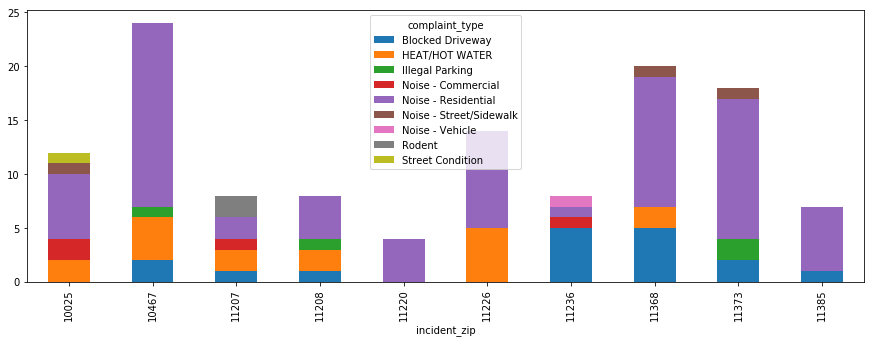

In [36]:
temp_df.groupby(['incident_zip','complaint_type'])['incident_zip'].agg(len).unstack().plot(kind='bar', stacked=True, figsize=(15,5))

## 3 - Considering all complaint types. Which boroughs are the biggest "complainers" relative to the size of the population in 2017? Meaning, calculate a complaint-index that adjusts for population of the borough

In [37]:
#Review dataset and data type for NYC borough population dataframe before joining on 'Zip Code ZCTA'
NYC_population_ZipCode.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401 entries, 10001 to 11694
Data columns (total 2 columns):
Zip Code ZCTA             401 non-null int64
2010 Census Population    401 non-null int64
dtypes: int64(2)
memory usage: 9.4 KB


In [38]:
#Review dataset and data type for 311 Serivce Requests dataframe before joining on incident_zip
nyc_df_dCols.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 11234 to 10036
Data columns (total 5 columns):
unique_key        1000 non-null int64
complaint_type    1000 non-null object
borough           1000 non-null object
city              1000 non-null object
incident_zip      1000 non-null int64
dtypes: int64(2), object(3)
memory usage: 66.9+ KB


In [39]:
#Test for the number of mismatch on joining dataframes on 'Zip Code ZCTA' and incident_zip
nyc_df_dCols.join(NYC_population_ZipCode).isna().sum()

unique_key                 0
complaint_type             0
borough                    0
city                       0
incident_zip               0
Zip Code ZCTA             10
2010 Census Population    10
dtype: int64

In [40]:
#Join 311 Service request and NYC borough population dataframes together on matching zip codes.
SR_311_NYC_population_ZipCode = nyc_df_dCols.join(NYC_population_ZipCode, how='inner')

In [41]:
#Review dataset and data types
SR_311_NYC_population_ZipCode.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 990 entries, 10001 to 11694
Data columns (total 7 columns):
unique_key                990 non-null int64
complaint_type            990 non-null object
borough                   990 non-null object
city                      990 non-null object
incident_zip              990 non-null int64
Zip Code ZCTA             990 non-null int64
2010 Census Population    990 non-null int64
dtypes: int64(4), object(3)
memory usage: 61.9+ KB


In [42]:
#Analyze share of tickets for borough with Census Population data
SR_311_NYC_population_ZipCode.groupby('borough')['2010 Census Population'].count()

borough
BRONX            185
BROOKLYN         311
MANHATTAN        244
QUEENS           224
STATEN ISLAND     26
Name: 2010 Census Population, dtype: int64

In [43]:
#Analyze share of population for borough with Census Population data
SR_311_NYC_population_ZipCode.groupby('borough')['2010 Census Population'].sum()

borough
BRONX            12839910
BROOKLYN         21617627
MANHATTAN        12140499
QUEENS           12521369
STATEN ISLAND     1371000
Name: 2010 Census Population, dtype: int64

In [44]:
#Define the aggregation procedure to be used outside of the groupby operation
aggregations = {
    'population_sum':'sum',
    'ticket_count': 'count',
    'complaint_index': lambda x : (len(x) / np.sum(x)) * 100
}

In [45]:
#Extract ticket and population size and calculate complaint index
SR_311_NYC_population_ZipCode.groupby('borough')['2010 Census Population'].agg(aggregations)

C:\Users\eche1\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,population_sum,ticket_count,complaint_index
borough,,,
BRONX,12839910,185,0.001441
BROOKLYN,21617627,311,0.001439
MANHATTAN,12140499,244,0.002010
QUEENS,12521369,224,0.001789
STATEN ISLAND,1371000,26,0.001896


In [46]:
#Plot
#SR_311_NYC_population_ZipCode.groupby('borough')['2010 Census Population'].agg(aggregations).unstack().plot(kind='bar', stacked=True, figsize=(15,5))